# Dependences

In [2]:
import sys
from pathlib import Path
import re
# Add the project root to sys.path
root_path = Path().resolve().parent
sys.path.append(str(root_path))

import polars as pl
import h3
from h3ronpy.pandas.vector import cells_dataframe_to_geodataframe
import h3ronpy.polars
import geopandas as gpd
from sklearn.model_selection import cross_validate
import joblib
import xgboost
import lightgbm
import catboost
import shap
import altair as alt
import folium
from folium import plugins
import matplotlib.pyplot as plt

# Load variables
from scripts.model.train import load_data, load_params, train
from scripts import (
    RAW_DATA_DIR, PROCESSED_DATA_DIR, TRAIN_FILE, TEST_FILE, MOBILITY_FILE, 
    AGG_MOBILITY_FILE, FULL_DATASET, MODEL_DATA_DIR, MODEL_FILE
)

# EDA

## Raw Data

### Overview

In [3]:
raw_train = pl.read_csv(RAW_DATA_DIR / TRAIN_FILE)
raw_test = pl.read_csv(RAW_DATA_DIR / TEST_FILE)
# Scan mobility data because is huge
ms = pl.scan_parquet(RAW_DATA_DIR / MOBILITY_FILE)
print("Train shape: ", raw_train.shape)
print("Test shape: ", raw_test.shape)
print("Mobility shape: ", (ms.select(pl.len()).collect()[0,0], len(ms.collect_schema())))
print("Train dataset head:", raw_train.head())
print("Test dataset head:", raw_test.head())
print("Mobility dataset head:", ms.head().collect())

Train shape:  (510, 2)
Test shape:  (511, 2)
Mobility shape:  (340411133, 4)
Train dataset head: shape: (5, 2)
┌─────────────────┬────────────────┐
│ hex_id          ┆ cost_of_living │
│ ---             ┆ ---            │
│ str             ┆ f64            │
╞═════════════════╪════════════════╡
│ 8866d338abfffff ┆ 0.372854       │
│ 8866d331b1fffff ┆ 0.424494       │
│ 888f2e3b4dfffff ┆ 0.414815       │
│ 888f2b9ae5fffff ┆ 0.687205       │
│ 8866d32363fffff ┆ 0.482482       │
└─────────────────┴────────────────┘
Test dataset head: shape: (5, 2)
┌─────────────────┬────────────────┐
│ hex_id          ┆ cost_of_living │
│ ---             ┆ ---            │
│ str             ┆ str            │
╞═════════════════╪════════════════╡
│ 888f2b983dfffff ┆ null           │
│ 888f2864b7fffff ┆ null           │
│ 8866d33813fffff ┆ null           │
│ 888f0d9acdfffff ┆ null           │
│ 8866d33a03fffff ┆ null           │
└─────────────────┴────────────────┘
Mobility dataset head: shape: (5, 4)
┌────

### Data types

In [4]:
print("Train dataset schema:")
print(raw_train.schema)

print("Test dataset schema:")
print(raw_test.schema)

print("Mobility dataset schema:")
print(ms.collect_schema())

Train dataset schema:
Schema([('hex_id', String), ('cost_of_living', Float64)])
Test dataset schema:
Schema([('hex_id', String), ('cost_of_living', String)])
Mobility dataset schema:
Schema([('device_id', Int32), ('lat', Float64), ('lon', Float64), ('timestamp', Int64)])


### Hex Resolution

In [5]:
sample_hex = raw_train.select(pl.col('hex_id'))[0,0]
resolution = h3.get_resolution(sample_hex)
print("Resolution of hex grid is: ", resolution)

Resolution of hex grid is:  8


### Mobility dataset

In [6]:
# Because this operation involves to use the entire dataset, I will do it column by column
for col in ms.collect_schema().names():
    print(ms.select(col).describe())
    print(ms.select(pl.col(col).approx_n_unique().alias(f"Number of uniques {col}")).collect(new_streaming=True))

shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ device_id     │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 3.40411133e8  │
│ null_count ┆ 0.0           │
│ mean       ┆ 1.0480e6      │
│ std        ┆ 603982.168434 │
│ min        ┆ 1.0           │
│ 25%        ┆ 525423.0      │
│ 50%        ┆ 1.048482e6    │
│ 75%        ┆ 1.564597e6    │
│ max        ┆ 2.104254e6    │
└────────────┴───────────────┘
shape: (1, 1)
┌─────────────────────────────┐
│ Number of uniques device_id │
│ ---                         │
│ u32                         │
╞═════════════════════════════╡
│ 2091079                     │
└─────────────────────────────┘
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ lat          │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 3.40411133e8 │
│ null_count ┆ 0.0          │
│ mean       ┆ -1.317196    │
│ std        ┆ 1.121266     │

## Processed Data

### Mobility dataset

In [7]:
ms_proc = pl.read_csv(PROCESSED_DATA_DIR / AGG_MOBILITY_FILE)

features = ['devices_count', 'duration_s']

chart = alt.hconcat()
for feature in features:
    chart |= (
        ms_proc
        .select(feature)
        .to_series()
        .qcut(50)
        .value_counts(sort=True)
        .plot.bar(x= feature, y='count')
        .properties(title=f'{feature} distribution', width = 500)
    )
(
    chart
    .configure_axisX(labels = False)
    .configure_axisY(title = '')
)

alt.HConcatChart(...)

### Full dataset

In [8]:
full_data = pl.read_csv(PROCESSED_DATA_DIR / FULL_DATASET)
print(full_data.shape)
full_data.describe()

(1021, 87)


shape: (9, 88)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ hex_id    ┆ cost_of_l ┆ train   ┆ … ┆ 13_1 Pair ┆ 13_1      ┆ 13_1 Pair ┆ 13_1 Pair │
│ ---        ┆ ---       ┆ iving     ┆ ---     ┆   ┆ of Jeans  ┆ Summer    ┆ of Nike   ┆ of Men    │
│ str        ┆ str       ┆ ---       ┆ f64     ┆   ┆ (Levis    ┆ Dress in  ┆ Running   ┆ Leather   │
│            ┆           ┆ f64       ┆         ┆   ┆ 501 …     ┆ a Chain   ┆ Shoe…     ┆ Busin…    │
│            ┆           ┆           ┆         ┆   ┆ ---       ┆ S…        ┆ ---       ┆ ---       │
│            ┆           ┆           ┆         ┆   ┆ f64       ┆ ---       ┆ f64       ┆ f64       │
│            ┆           ┆           ┆         ┆   ┆           ┆ f64       ┆           ┆           │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 1021      ┆ 510.0     ┆ 1021.0  ┆ … ┆ 1021.0    ┆ 1021.0    ┆ 1021.0    ┆ 1021.0    │
│ null_count ┆ 0         ┆ 511.0     ┆ 0.0     ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ null      ┆ 0.434846  ┆ 0.49951 ┆ … ┆ 72.13869  ┆ 57.953416 ┆ 109.19785 ┆ 98.718749 │
│            ┆           ┆           ┆         ┆   ┆           ┆           ┆ 8         ┆           │
│ std        ┆ null      ┆ 0.19183   ┆ null    ┆ … ┆ 3.05821   ┆ 4.294371  ┆ 1.107235  ┆ 9.836808  │
│ min        ┆ 8866d14d0 ┆ 0.152048  ┆ 0.0     ┆ … ┆ 63.602024 ┆ 54.356029 ┆ 106.70083 ┆ 77.422593 │
│            ┆ 5fffff    ┆           ┆         ┆   ┆           ┆           ┆ 3         ┆           │
│ 25%        ┆ null      ┆ 0.296405  ┆ null    ┆ … ┆ 72.398452 ┆ 54.356029 ┆ 108.7125  ┆ 95.09373  │
│ 50%        ┆ null      ┆ 0.384109  ┆ null    ┆ … ┆ 72.398452 ┆ 54.647533 ┆ 108.7125  ┆ 95.09373  │
│ 75%        ┆ null      ┆ 0.53506   ┆ null    ┆ … ┆ 73.832296 ┆ 63.149689 ┆ 110.16178 ┆ 108.77160 │
│            ┆           ┆           ┆         ┆   ┆           ┆           ┆ 6         ┆ 5         │
│ max        ┆ 888f76d6e ┆ 1.0       ┆ 1.0     ┆ … ┆ 73.832296 ┆ 63.149689 ┆ 110.16178 ┆ 108.77160 │
│            ┆ dfffff    ┆           ┆         ┆   ┆           ┆           ┆ 6         ┆ 5         │
└────────────┴───────────┴───────────┴─────────┴───┴───────────┴───────────┴───────────┴───────────┘

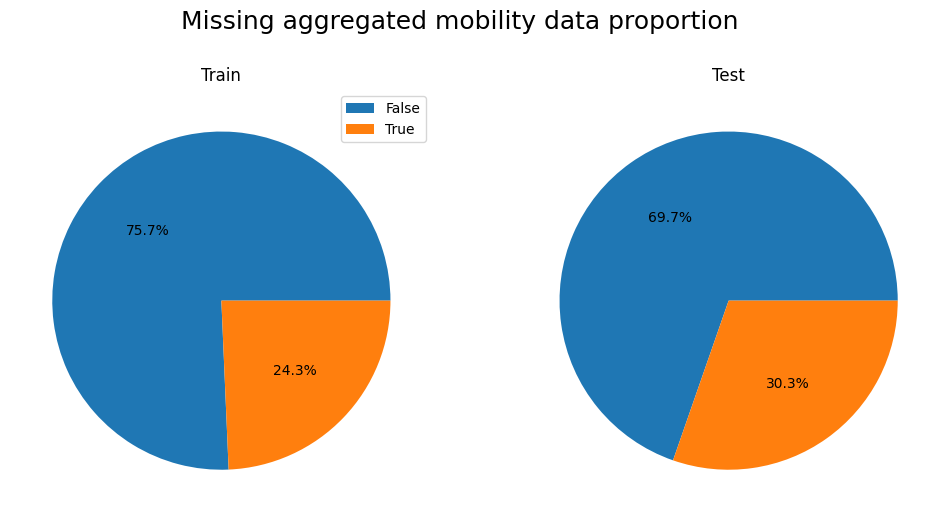

In [9]:
df = full_data.to_pandas()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

df.query("train == True")['devices_count'].isnull().value_counts().plot.pie(ax=ax[0], title='Train', autopct='%1.1f%%', legend=True, labels=None)
df.query("train == False")['devices_count'].isnull().value_counts().plot.pie(ax=ax[1], title='Test', autopct='%1.1f%%', labels=None)
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.suptitle('Missing aggregated mobility data proportion', fontsize=18)
plt.show()

#### Maps

In [10]:
# Parse hex_id
data = full_data.with_columns(pl.col('hex_id').h3.cells_parse().alias('cell'))
# Convert dataframe to geopandas dataframe
gdf = cells_dataframe_to_geodataframe(data.to_pandas(), 'cell')

In [11]:
def plot_heatmap(gdf):
    center = [gdf['lat'].mean(), gdf['lon'].mean()]
    map = folium.Map(location=center, tiles="Cartodb dark_matter", zoom_start=7)

    heat_data = [[point.centroid.xy[1][0], point.centroid.xy[0][0]] for point in gdf.geometry]
    plugins.HeatMap(heat_data).add_to(map)
    return map

plot_heatmap(gdf)

In [12]:
def hexagons_map(gdf):
    center = [gdf['lat'].mean(), gdf['lon'].mean()]
    map = folium.Map(location=center, zoom_start=8, tiles='CartoDB Positron')
    return map

map = hexagons_map(gdf)
features = ["province", "county", "district", "neighbourhood", "cost_of_living", "devices_count", "duration_s"]
for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    color = "blue" if r["train"] else "red"
    geo_j = folium.GeoJson(
        data=geo_j,
        style_function=lambda x, color=color: {"fillColor": color, "color": "gray", "weight": 1.5, "fillOpacity": 0.3},
    )
    folium.Popup("\n".join(f"<b>{feature.capitalize()}</b>: {r[feature]}" for feature in features)).add_to(geo_j)
    geo_j.add_to(map)
map

#### Correlation

In [13]:

# Calculate correlations
corr_mat = (
    full_data
    # Encode categorical columns to ordinal
    .with_columns(pl.col(pl.String).cast(pl.Categorical).to_physical())
    .to_pandas()
    .corr()
    .reset_index()
)
# Convert to long format for Altair
correlation_long = (
    corr_mat
    .melt(id_vars = 'index', var_name="feature", value_name="correlation")
)

In [14]:
alt.data_transformers.disable_max_rows() # to avoid truncation
# Heatmap using Altair
heatmap = (
    alt.Chart(correlation_long)
    .mark_rect()
    .encode(
        x="index:O",
        y="feature:O",
        color="correlation:Q",
        tooltip=["index", "feature", "correlation"]
    )
    .properties(
        width=800,
        height=800
    )
    .configure_axisX(title = None)
    .configure_axisY(title = None)
)

# Show the plot
heatmap.show()

alt.Chart(...)

There are many correlated features, as expected.

# Model

## Loading

In [15]:
X_train, y_train, X_test = load_data()
pipe = train(X_train, y_train, seed=42)
pipe

2025-03-17 10:23:30-root-INFO - Loading /home/sagravela/code/alt-score-challenges/e10/data/processed/full_dataset.csv.
2025-03-17 10:23:30-root-INFO - Loading models params from /home/sagravela/code/alt-score-challenges/e10/model/params.json.
/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.w

Pipeline(memory='/home/sagravela/code/alt-score-challenges/e10/model',
         steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f53f6110310>),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.co...
                                              LGBMRegressor(colsample_bytree=0.6578993834924656,
                                                            learning_rate=0.19982810380120172,
                                                            max_depth=6,
                                                            min_child_samples=18,
                                                            min_split_gain=0.0035579232560428277,
                                                            n_estimators=233,
                                                            num_leaves=43,
                                                            reg_alpha=0.39987368838186493,
                                                            reg_lambda=1.4659252604806086,
                                                            seed=42,
                                                            subsample=0.6640976531017576,
                                                            verbosity=-1)),
                                             ('cat',
                                              <catboost.core.CatBoostRegressor object at 0x7f53f73f2710>)]))])

## Evaluation

In [16]:
scores = cross_validate(pipe, X_train, y_train, scoring="neg_root_mean_squared_error")
for key, value in scores.items():
    print(f"{key.upper()}: {value} (Avg {value.mean()})")

/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sa

FIT_TIME: [0.41682172 0.43071055 0.41358519 1.30066967 0.85049915] (Avg 0.6824572563171387)
SCORE_TIME: [0.01715636 0.0175333  0.01888037 0.02060056 0.01832747] (Avg 0.01849961280822754)
TEST_SCORE: [-0.15574535 -0.15770433 -0.13439867 -0.13589907 -0.14780477] (Avg -0.1463104382077965)


/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Inspection

In [17]:
def explain(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    return shap.summary_plot(shap_values, X, max_display=10)

X_train_proc = pipe[:-1].set_output(transform="pandas").transform(X_train)
X_test_proc = pipe[:-1].set_output(transform="pandas").transform(X_test)

xgb_params, lgbm_params, cat_params = load_params()

/home/sagravela/code/alt-score-challenges/e10/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


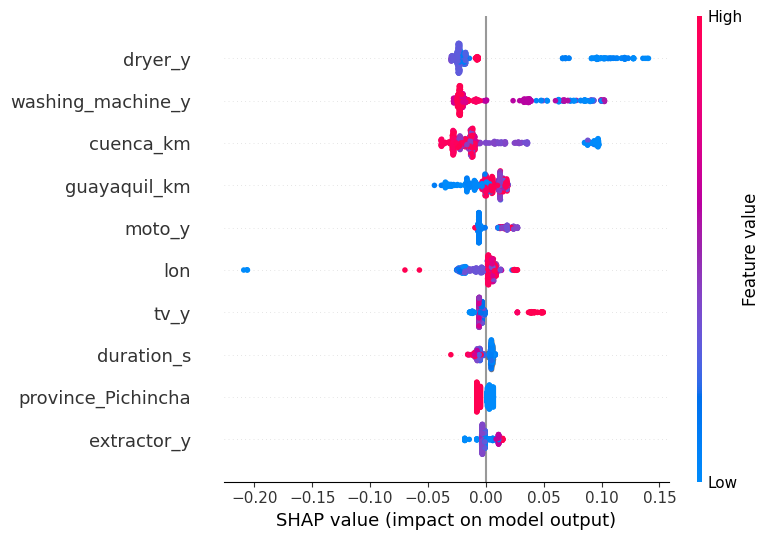

In [18]:
# CatBoost SHAP values
cat = catboost.CatBoostRegressor(**cat_params, verbose=0, random_seed=42, allow_writing_files=False)
cat.fit(X_train_proc, y_train)
plot = explain(cat, X_test_proc)

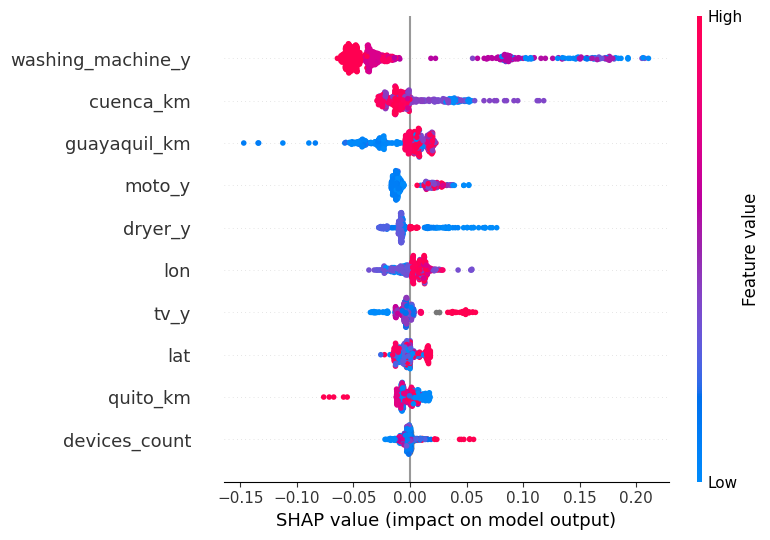

In [19]:
# XGBoost SHAP values
xgb = xgboost.XGBRegressor(**xgb_params, verbosity=0, seed=42)
xgb.fit(X_train_proc, y_train)
explain(xgb, X_test_proc)

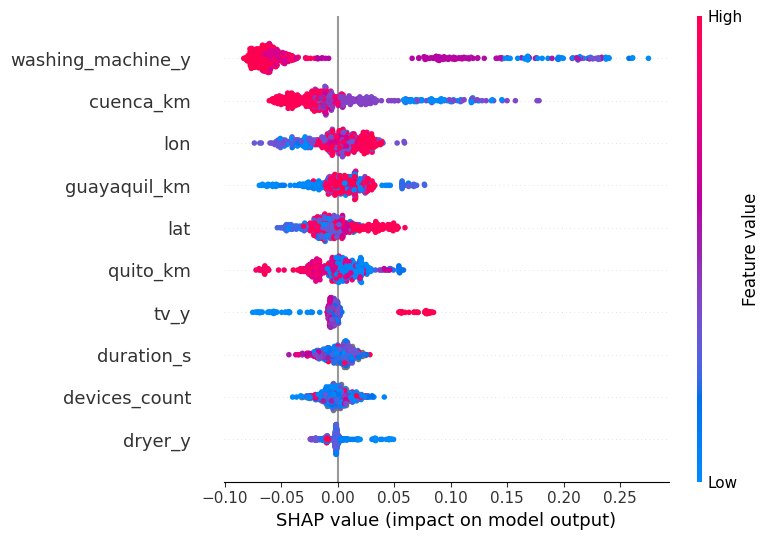

In [20]:
# LightGBM doesn't support some special characters in column names
X_train_proc = X_train_proc.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# LightGBM SHAP values
lgbm = lightgbm.LGBMRegressor(verbosity=-1, seed=42)
lgbm.fit(X_train_proc, y_train)
explain(lgbm, X_test_proc)

Most important features accross the models are the following: 
- `washing_machine_y`
- `cuenca_km`
- `guayaquil_km`
- `dryer_y`
- `lat`
- `lon`
- `tv_y`
- the aggregated mobility features `devices_count` and `duration_s`.